In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data

In [4]:
pwd

'/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification'

In [5]:
!head -2 ../../FinalProject/hein-daily/speeches_097.txt

head: ../../FinalProject/hein-daily/speeches_097.txt: No such file or directory


In [6]:
!cat ../../FinalProject/hein-daily/speeches_097.txt | wc -l

cat: ../../FinalProject/hein-daily/speeches_097.txt: No such file or directory
       0


In [7]:
data_path = '../../FinalProject/hein-daily/Sample'

In [8]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [9]:
len(all_speech_ids), len(all_speeches)

(283399, 283399)

## Create target labels

#### TODO:

- Why is this taking so much time?
- Subset on word cound here?
- Make sampling replicable: random seed + random array of proper length

In [10]:
reload(load_data)
start_time = time.time()
# remove p if want to run for the full speech file
descr = load_data.load_descr_data('../data/QA/full_descr.txt', p=0.3)
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
7227 keys had duplicates and deleted
The dictionary has 858639 keys

Random congressperson: 970167231
date 19820513
char_count 164
word_count 33
speakerid 97104811.0
Party R
Congress 97
Chamber S
State TN
Ethnicity W
Age 57.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. BAKER
Full Name BAKER, HOWARD
match exact
check 1

It took 6.3 seconds to create the dictionary


In [11]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.29461300602786655

In [12]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(283399, 283399, 283399, 283399, 283399, 283399)

### Data QA

In [13]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,216551
1,0,65477
2,1,1371


Target group number of speeches by party:
D: 	 664
I: 	 0
N: 	 0
NA: 	 -216551
R: 	 707

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,216551
1,0,64037
2,1,2811


Target group number of speeches by party:
D: 	 2405
I: 	 0
N: 	 45
NA: 	 -216551
R: 	 361

 Age
Overall speech counts:


,Category,Count
0,-1,216551
1,0,43720
2,1,23128


Target group number of speeches by party:
D: 	 12400
I: 	 0
N: 	 45
NA: 	 -216551
R: 	 10683


In [15]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, gender, descr)

Speaker information
date 19810626
char_count 1073
word_count 184
speakerid 97120530.0
Party D
Congress 97
Chamber H
State MD
Ethnicity W
Age 46.0
Age_lt_med 1.0
NonWhite 0.0
Female 1.0
speaker Ms. MIKULSKI
Full Name MIKULSKI, BARBARA
match exact
check 1

Mr. Speaker. I rise as both a member of the committee and a member of the Steel Caucus to lend my endorsement to this legislation. which literally and legislatively provides the qteel industry with a muchneeded breather. without forsaking the goals of clean air. For someone yvho represents a community such as mine. where we have both unemployed steelworkers and yet one of the highest rates of lung disease in the country. we needed to find a way to keep our people working. and also a way to keep our people breath. ing. I think this legislation shows the kind of partnership and substance that enables that to happen. I wholeheartedly endorse it. Mr. Speaker. in these rancorous times within this House. where there is bitterness and even fo

In [16]:
explore_data.random_speech(all_speeches, all_speech_ids, ethnicity, descr)

Speaker information
date 19820929
char_count 172
word_count 32
speakerid 97106770.0
Party D
Congress 97
Chamber H
State TX
Ethnicity ME
Age 63.0
Age_lt_med 0.0
NonWhite 1.0
Female 0.0
speaker Mr. KAZEN
Full Name KAZEN, ABRAHAM
match exact
check 1

I appreciate the gentleman saying that because this is certainly what we had in mind. In order to get a well rounded. a complete study. we must have input from all sources.


In [17]:
explore_data.random_speech(all_speeches, all_speech_ids, age, descr)

Speaker information
date 19811216
char_count 1178
word_count 219
speakerid 97115351.0
Party D
Congress 97
Chamber S
State DE
Ethnicity W
Age 40.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. BIDEN
Full Name BIDEN, JOSEPH
match exact
check 1

I do not claim to be an expert in this area. but I am under the impression. not officially from the justice Department. but from Prosecutors. that. in fact. one of the more useful tools they have had to crimp national bookmaking syndicates has been the availability of both this excise tax and the tax on wages. I. In the late hours of this session..for one would not want to make a Judgment otherwise. without longer debate on this. I am certainly not going to extend the debate on this. But If the manager of the bill Is going to accept this amendment. I would ask that we have a rollcall vote. I want to make it clear that I oppose this amendment. even though if I had more information and time to query the Justice Department on this matter. I migh

## Split into train, validate, test

### Filter on party if necessary

In [18]:
# reload(load_data)
# all_speeches_d, all_speech_ids_d, gender_d = load_data.filter_data(all_speeches, all_speech_ids, gender, party, 'D')
# len(all_speeches_d), len(all_speech_ids_d), len(gender_d)

In [19]:
# reload(explore_data)
# explore_data.get_counts(gender_d)

### Split into train/val/test

### Split by congress

In [20]:
# reload(preprocess_data)
# train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_by_congress(all_speeches, all_speech_ids, gender, descr, congress)

In [22]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, age, descr)

Training split: 7999 ones and 7999 zeroes
Training speech list size: 15998
Training target list size: 15998
Validation split: 2666 ones and 2666 zeroes
Validation speech list size: 5332
Validation target list size: 5332
Test split: 2667 ones and 2667 zeroes
Test speech list size: 5334
Test target list size: 5334


In [23]:
sum(train_target), sum(val_target), sum(test_target)

(7999, 2666, 2667)

In [25]:
# number of speeches under 30 words
sum(np.array(age)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

9796

In [26]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19811028
char_count 4620
word_count 763
speakerid 97112651.0
Party R
Congress 97
Chamber S
State OK
Ethnicity W
Age 34.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker MAN. NICKLES
Full Name NICKLES, DON
match exact
check 1

DECONCI NI. STENNNs. JOHNSTON. PRYOR. HOLLINGS. and HATCH. I am today reintroducing the provisions of S. 1163. the Labor Racketeering Act of 1981.5S. 1163 was originally Introduced by me on May 12. 1981. and was designed to help ease the problems of corruption on the Nations waterfront. Since introducing S. 1163 in May. we have consulted with many groups both inside and outside of Government. We have received many recommendations and suggestions to clarify and tighten S. 1163. The bill which I am introducing today contains all of the essential provisions of S. 1163. but with what we believe to be substantial improvements which represent the views and input of all parties. The technical ch~nges we are making have no substantive effect on the

## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [27]:
reload(explore_data)

<module 'helpers.explore_data' from '/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification/helpers/explore_data.py'>

In [28]:
explore_data.get_num_words_per_sample(train)

185.0

In [29]:
explore_data.get_num_words_per_sample(val)

181.0

In [30]:
explore_data.get_num_words_per_sample(test)

184.0

Speech length percentiles
    0     10    20    30     40     50     60     70     80     90      100
0  31.0  42.0  61.0  90.0  131.0  185.0  250.0  342.0  484.0  775.0  8421.0


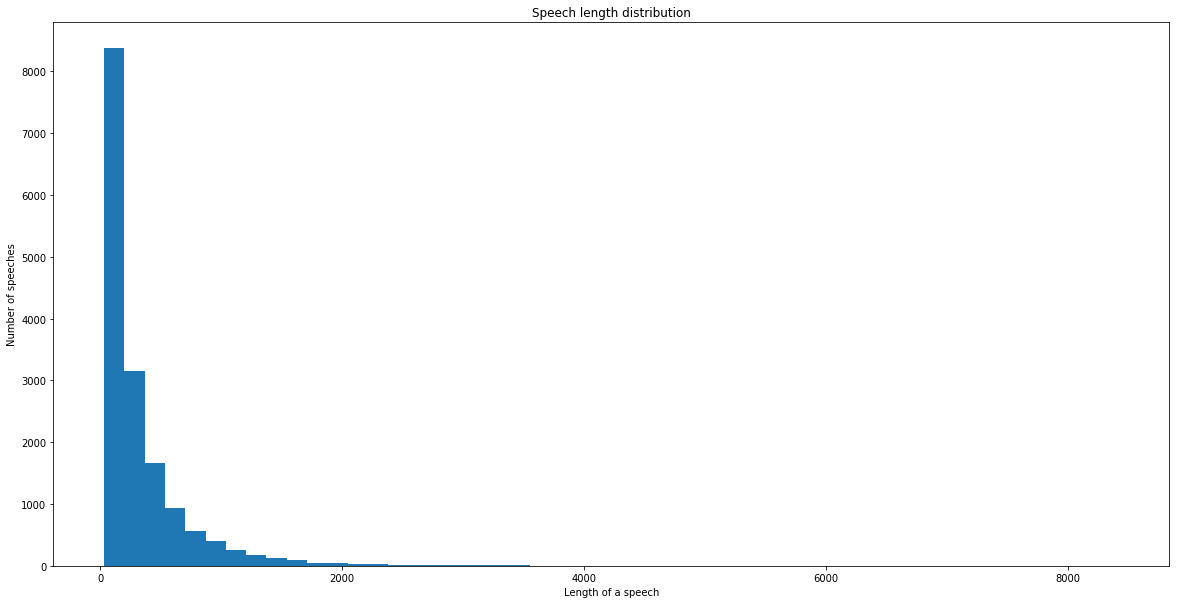

In [31]:
reload(explore_data)
explore_data.plot_sample_length_distribution(train)

### Most popular unigrams (training only)

In [32]:
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

3199

['the', 'of', 'to', 'and', 'in', 'that', 'is', 'for', 'this', 'it', 'we', 'on', 'be', 'have', 'not', 'as', 'are', 'by', 'with', 'will', 'from', 'mr', 'has', 'would', 'our', 'which', 'was', 'an', 'at', 'or', 'president', 'my', 'they', 'their', 'been', 'but', 'he', 'all', 'bill', 'his', 'who', 'do', 'if', 'these', 'amendment', 'there', 'more', 'one', 'time', 'committee']


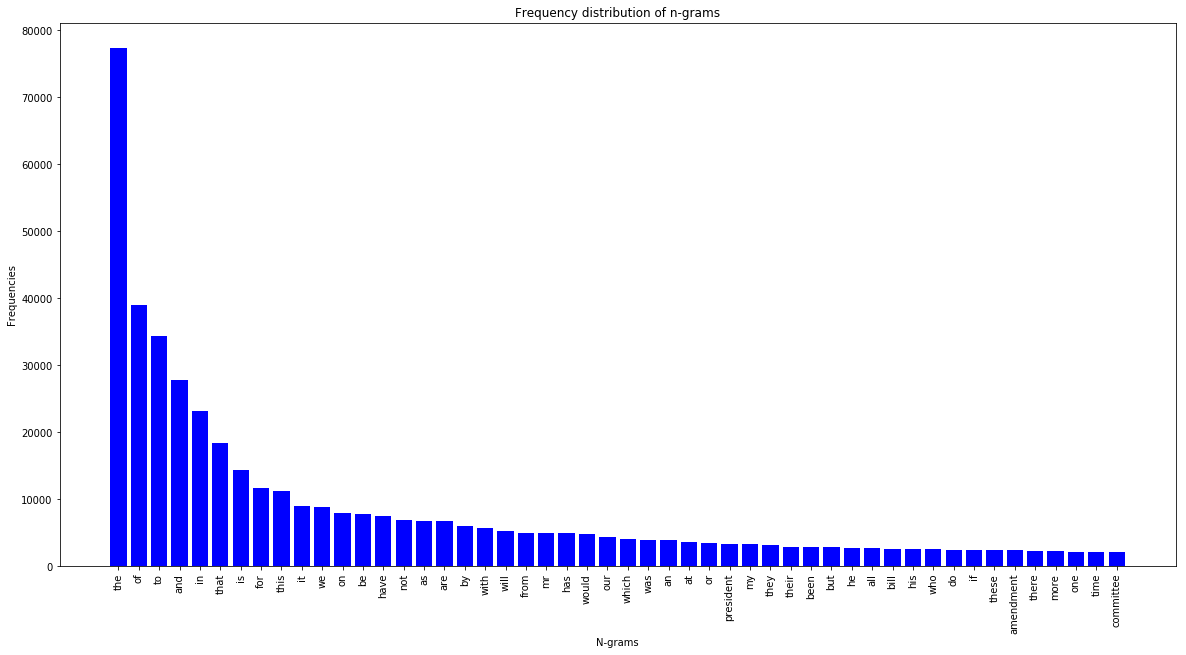

In [33]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

### Most popular bigrams (training only)

['of the', 'in the', 'to the', 'it is', 'that the', 'for the', 'and the', 'on the', 'by the', 'mr president', 'to be', 'with the', 'of this', 'mr speaker', 'we are', 'we have', 'that we', 'will be', 'in this', 'that is', 'the united', 'the senate', 'united states', 'has been', 'from the', 'at the', 'have been', 'is the', 'would be', 'the gentleman', 'the house', 'is not', 'of our', 'do not', 'going to', 'the senator', 'senator from', 'my colleagues', 'there is', 'as the', 'the federal', 'the committee', 'the bill', 'the president', 'this is', 'this bill', 'one of', 'the same', 'to make', 'this amendment']


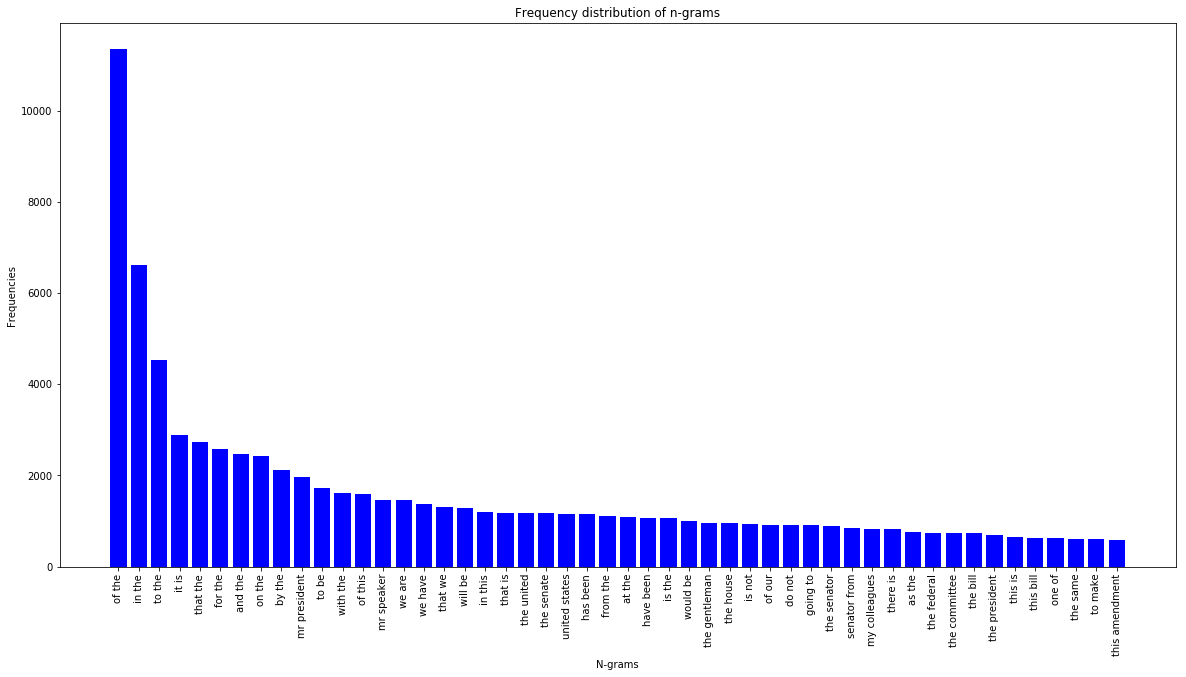

In [34]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

### Most popular trigrams (training only)

['the united states', 'the senator from', 'would like to', 'the gentleman from', 'one of the', 'the department of', 'chairman of the', 'are going to', 'of the united', 'the federal government', 'ask unanimous consent', 'the soviet union', 'in the record', 'of the senate', 'unanimous consent that', 'of the house', 'as well as', 'the american people', 'is going to', 'members of the', 'the fact that', 'in order to', 'percent of the', 'my colleagues to', 'it is not', 'there is no', 'member of the', 'we are going', 'in this country', 'that it is', 'that we have', 'in the united', 'the committee on', 'of my colleagues', 'the people of', 'the secretary of', 'house of representatives', 'going to be', 'the house of', 'that we are', 'be able to', 'in support of', 'some of the', 'part of the', 'mr president the', 'urge my colleagues', 'we do not', 'of the committee', 'the state of', 'in the senate']


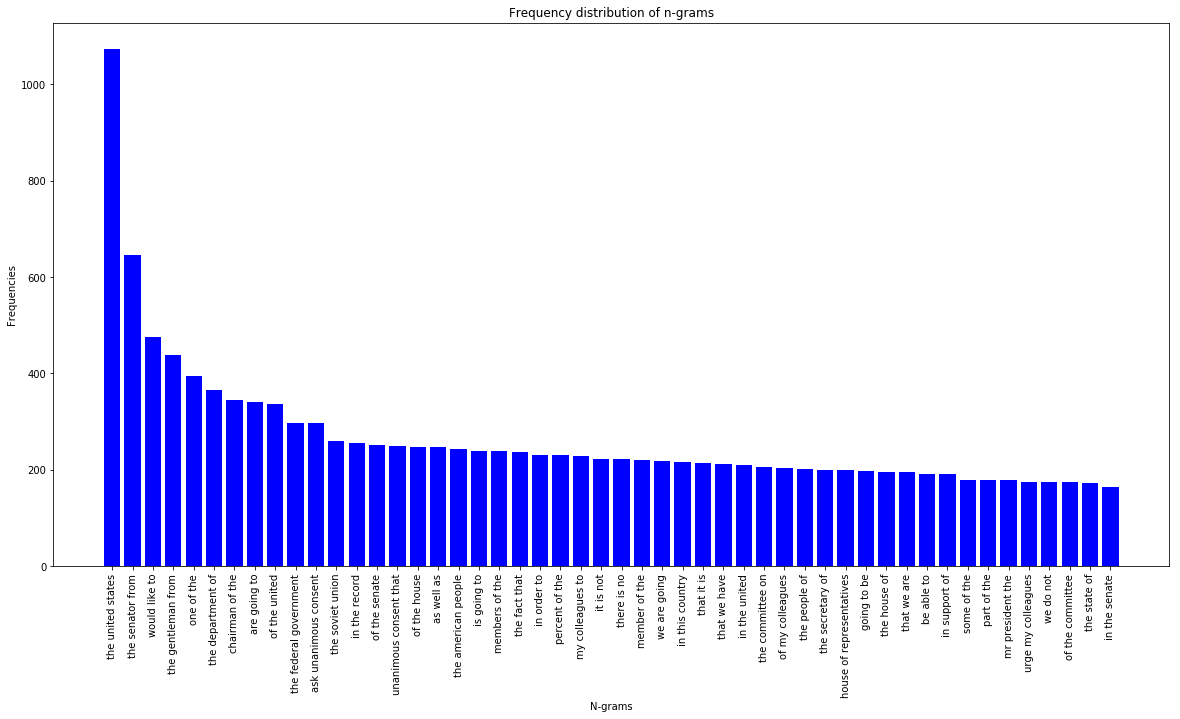

In [35]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [36]:
congress = set([str(i) for i in range(97,115)])

In [37]:
len(train)

15998

In [38]:
descr['1110063404']

{'date': '20090930',
 'char_count': '1356',
 'word_count': '244',
 'speakerid': '111118281.0',
 'Party': 'R',
 'Congress': '111',
 'Chamber': 'S',
 'State': 'TN',
 'Ethnicity': 'W',
 'Age': '70.0',
 'Age_lt_med': '0.0',
 'NonWhite': '0.0',
 'Female': '0.0',
 'speaker': 'Mr. ALEXANDER',
 'Full Name': 'ALEXANDER, LAMAR',
 'match': 'exact',
 'check': 1}

In [39]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3, top_n=5)


For Congress 97 top 5 (3, 3) ngrams are:
the united states
the senator from
would like to
the gentleman from
one of the
--------------------


## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [40]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Output number of top/bottom scoring ngrams
TOP_N = 5

vec_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [41]:
reload(preprocess_data)
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **vec_params)

Total vocabulary size: 130869
Number of stop words 1130446

Top 5 ngrams by differentiating score:
mr president 	 367.1
consent 	 273.3
unanimous 	 268.8
unanimous consent 	 265.6
president 	 238.5

Bottom 5 ngrams by differentiating score:
rejectionist 	 0.0
the entitlements 	 0.0
provoked 	 0.0
know which 	 0.0
representatives has 	 0.0


In [42]:
len(train), len(val), len(test)

(15998, 5332, 5334)

In [43]:
train_vec.shape, val_vec.shape, test_vec.shape

((15998, 20000), (5332, 20000), (5334, 20000))

### Saving processed files

In [44]:
pwd

'/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification'

In [45]:
data_path = '../../FinalProject/saved_files'

In [46]:
scipy.sparse.save_npz(os.path.join(data_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'test_vec.npz'), test_vec)

In [47]:
train_vec = scipy.sparse.load_npz(os.path.join(data_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(data_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(data_path, 'test_vec.npz'))

In [48]:
train_vec.shape, val_vec.shape, test_vec.shape

((15998, 20000), (5332, 20000), (5334, 20000))

In [49]:
with open(os.path.join(data_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(data_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(data_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(data_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(data_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(data_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(data_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(data_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(data_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [50]:
sum(train_target), sum(val_target), sum(test_target)

(7999, 2666, 2667)

In [51]:
with open(os.path.join(data_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(data_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(data_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)
with open(os.path.join(data_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(data_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(data_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(data_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(data_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(data_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [52]:
sum(train_target), sum(val_target), sum(test_target)

(7999, 2666, 2667)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [53]:
logs_base_dir = '../../FinalProject/logs'

In [54]:
ngram_model_params = {
    'model': 'ngram',
    'log_dir': logs_base_dir,
    'learning_rate': 1e-3,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2
}

In [55]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), **ngram_model_params)

Train on 15998 samples, validate on 5332 samples
Epoch 1/1000
 - 18s - loss: 0.6472 - acc: 0.6575 - val_loss: 0.6436 - val_acc: 0.6217
Epoch 2/1000
 - 18s - loss: 0.5330 - acc: 0.7692 - val_loss: 0.6311 - val_acc: 0.6332
Epoch 3/1000
 - 17s - loss: 0.4237 - acc: 0.8432 - val_loss: 0.6415 - val_acc: 0.6298
Epoch 4/1000
 - 17s - loss: 0.3394 - acc: 0.8862 - val_loss: 0.6648 - val_acc: 0.6285
Validation accuracy: 0.6284696173149218, loss: 0.6647848848641947


## Model evaluation

In [56]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

3351

Confusion matrix, without normalization
[[1581 1085]
 [ 896 1770]]


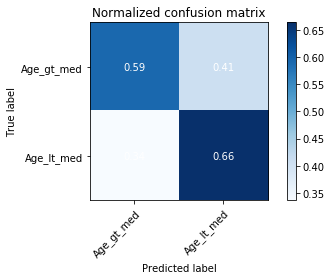

In [57]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Age_gt_med', 'Age_lt_med']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

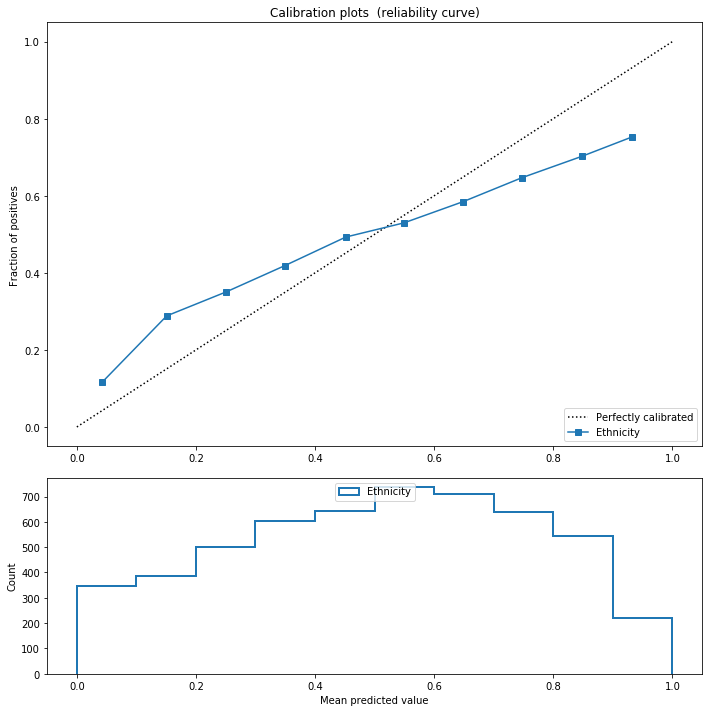

In [58]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Ethnicity')

In [59]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.2897599399849963

In [60]:
val_sample, val_ids_sample, val_pred_probs_sample = [], [], []
for i in range(len(val_ids)):
    if val_random[i] == 1:
        val_sample.append(val[i])
        val_ids_sample.append(val_ids[i])
        val_pred_probs_sample.append(val_pred_probs[i])
len(val_sample), len(val_ids_sample), len(val_pred_probs_sample)

(1545, 1545, 1545)

In [61]:
descr_df = pd.read_csv('../data/QA/full_descr.txt', sep="|", index_col=0)
descr_df.shape

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2914464, 16)

In [62]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_pred_probs, val_ids, descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.079474       0.087358  58.324787  0.520156   0.563685    232.456109


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.15,0.37,0.95,0.86,0.72,1.10
0.6,0.40,0.54,0.89,1.00,1.06,1.43
1.0,0.49,0.56,0.84,1.06,1.17,1.67


In [127]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs)


Top 10 ngrams by differentiating score:
the senator from 	 11.6
our national security 	 10.4
the distinguished senator 	 10.2
the distinguished senator from 	 10.0
distinguished senator from 	 9.5
one of the 	 9.1
the soviet union 	 8.5
mr president ask 	 8.4
president ask unanimous 	 6.8
president ask unanimous consent 	 6.8


bin,1,2,3
distinguished senator from,26.0,0.0,2.0
mr president ask,16.0,1.0,3.0
one of the,13.0,22.0,56.0
our national security,0.0,12.0,1.0
president ask unanimous,14.0,1.0,3.0
president ask unanimous consent,14.0,1.0,3.0
the distinguished senator,27.0,1.0,2.0
the distinguished senator from,25.0,0.0,2.0
the senator from,53.0,5.0,9.0
the soviet union,39.0,4.0,3.0


In [63]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

the senator from
the united states
ask unanimous consent
the gentleman from
unanimous consent that
ask unanimous consent that
of the senate
the committee on
of the bill
would like to
--------------------

In 0.6 bin top 10 ngrams:

the united states
would like to
the senator from
are going to
chairman of the
the department of
the federal government
one of the
in the record
the gentleman from
--------------------

In 1.0 bin top 10 ngrams:

the united states
would like to
the gentleman from
the federal government
one of the
the senator from
the american people
my colleagues to
as well as
the soviet union
--------------------


In [64]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.94):

date                    19820715
char_count                  1622
word_count                   281
speakerid            9.71068e+07
Party                          D
Congress                      97
Chamber                        H
State                         GA
Ethnicity                      W
Age                           47
Age_lt_med                     1
NonWhite                       0
Female                         0
speaker             Mr. McDONALD
Full Name     MCDONALD, LAWRENCE
match                      fuzzy
Name: 970199349, dtype: object

 Mr. Speaker. ear. lier today. I cast a "nay" vote on H.R. 6687. the socalled urgent supplemen tal appropriations. As the legislation July 15. 1982 CONGR allows the Federal Government to spend another $5.5 billion of the money earned by the taxpayers of this Nation. I had little difficulty in opposing it. However. I did not oppose all provisions of the bill. A provision of H.R. 6687 repeals the sp